In [405]:
import numpy as np
import pandas as pd
import re
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16.,8.)

In [406]:
def form_discrete_values(funcs, y, orders):
    """ This function is used to present values of a model (Ferhulst for example)
        in an apropriate view of the table with first columns, referring to x, and lthe last one 
        to y. THE FUNCTION WORKS ONLY IN CASE STEP OF DISCRETIZATION IS 1 (any atempts aimed at fixing that
        caused a general formula to change (that is, each model would require its own discretization function
        that is shit, I reckon))
        @Parameters:
        1) funcs - contains an array of lambdas, to be applied to columns
        2) y - a column with output values
        3) orders - an array of integers, used to refer to lagging (for example, orders = 2, means, that
        the column is considered to be y[t - 2])"""
    x = np.array([[func(y[t - order, 0]) for func, order in zip(funcs, orders)] for t in range(orders[0], y.shape[0])])
    return np.hstack((x, y[orders[0]:]))


class Approximator(object):
    """ @Parameters:
        1) data - a table, where first columns are features and the last one is output
        2) teta - unknown parameters to be evaluated
        3) variance - unknown variance to be found
        This class is used to get linear approximation (using OMNK algo) and
        to calculate thereby variance, Akaike and Mallows coefficients"""
    def __init__(self, data):
        self.data = data
        self.teta = None
        self.variance = 0
        self.factors = None
        
    def get_tetas(self, factors):
        """ @Parameters:
            1) factors - represents amount of factors to be accounter into (might not exceed the
            size of the self.data)
            This function implements OMNK algorithm, which recursively evaluates unknown coefficients
            by gradually adding columns to  X.T@X matrix and therefore requiring as much as there are
            columns present to complete. At the same time variance is also evalueted recursively"""
        n, m = self.data.shape
        self.factors = factors
        Hs = np.array([[(self.data[:, 0].T @ self.data[:, 0])]])
        h = np.array([[self.data[:, 0] @ self.data[:, 1]]])
        eta = np.array([[self.data[:, 0].T @ self.data[:, 0]]])
        Hs_inv = np.linalg.inv(Hs)
        teta = [self.data[:, :1].T @ self.data[:, -1] / (self.data[:, :1].T @ self.data[:, :1])]
        P = np.eye(n) - (self.data[:, :1] @ np.linalg.inv(self.data[:, :1].T 
                                          @ self.data[:, :1]) @ self.data[:, :1].T)   
        variance = self.data[:, -1].T @ P @ self.data[:, -1]
        
        for i in range(1, factors):
            
            h = np.array([self.data[:, :i].T @ self.data[:, i]])
            eta = np.array([[self.data[:, i].T @ self.data[:, i]]])
            
            Hs_1 = Hs
            Hs_2 = h.T
            Hs_3 = h
            Hs_4 = eta
            beta = eta - h @ Hs_inv @ h.T
            
            D = np.eye(n) - self.data[:, :i] @ Hs_inv @ self.data[:, :i].T
            coefficient = self.data[:, i].T @ D @ self.data[:, i]
            variance -= (teta[-1] ** 2) * beta
            
            Hs = np.hstack((np.vstack((Hs_1, Hs_3)), np.vstack((Hs_2, Hs_4))))

            Hs_inv_1 = Hs_inv + (1 / beta) * Hs_inv @ h.T @ h @ Hs_inv
            
            Hs_inv_2 = -(1 / beta) * Hs_inv @ h.T
            Hs_inv_3 = -(1 / beta) * h @ Hs_inv
            Hs_inv_4 = (1 / beta)
            
            Hs_inv = np.hstack((np.vstack((Hs_inv_1, Hs_inv_3)), np.vstack((Hs_inv_2, Hs_inv_4))))
            
            gs = np.hstack((self.data[:, :i].T @ self.data[:, -1], self.data[:, i].T @ self.data[:, -1]))
            
            teta = Hs_inv @ gs

        self.teta = teta
        self.variance = variance
        return teta
    
    def get_variance(self):
        return self.variance
    
    def get_sigma_evaluation(self):
        n, m = self.data.shape
        return self.variance / (n - m)
    
    def get_Mallows(self):
        n, m = self.data.shape
        return self.variance + self.get_sigma_evaluation() * (2 * m - n)
    
    """
    def get_Akaike(self):
        n, m = self.data.shape
        return self.variance * ((n + m)/ (n - m))
    """
    
    def get_Akaike(self):
        n, m = self.data.shape
        s = self.factors
        return self.variance * ((n + s)/ (n - s ))
    
    def get_params(self, formulas):
        params = list(map(lambda formula: formula(self.teta), formulas))
        return params

class Model:
    def __init__(self, system, name):
        self.system = system
        self.name = name
        self.solved = None
        self.time_points = None
        self.initial_condition = None
        self.params = None
    
    def get_values(self, step):
        data = self.solved[:, 0][::step]
        return data.reshape((data.shape[0], 1))
    
    def build(self, params, initial_condition, time_points):
        self.params = params
        self.time_points = time_points
        self.initial_condition = initial_condition
        self.solved = odeint(self.system, initial_condition, time_points, args=tuple(self.params.values()))
            
    def get_data(self, index):
        if index == 0:
            return pd.DataFrame({'t': self.time_points, 'X(t)': self.solved[:, 0]})
        if index == 1:
            return pd.DataFrame({'t': self.time_points, 'Y(t)': self.solved[:, 1]})
        else:
            return pd.DataFrame({'X': self.solved[:, 0], 'Y': self.solved[:, 1]})
    
    def plot(self, plot_y=True):
        plt.figure(0)
        plt.plot(self.time_points, self.solved[:, 0])
        if plot_y:
            plt.plot(self.time_points, self.solved[:, 1])
        params = re.findall("[^}'{']", str(re.sub(': ', '=', str(self.params))))
        plt.title(self.name + ' with params: \n' +  ''.join(params), fontsize=15)
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)
    
    
    def phase_plot(self):
        plt.figure(1)
        plt.xlabel('X', fontsize=15)
        plt.ylabel('Y', fontsize=15)
        plt.scatter(self.solved[0,0], self.solved[0, 1])
        plt.plot(self.solved[:,0], self.solved[:, 1])
        plt.title(self.name + ' ' + 'phase plot\n', fontsize=15)
        
        #plt.plot([x*self.params[0]/self.params[1] - self.params[2]/self.params[0] for x in self.time_points])
        #plt.plot([y*self.params[3]/self.params[4] - self.params[5]/self.params[3] for y in self.time_points])

## Lotka-Volterra model

In [407]:
def Lotka_Volterra(z, t, a, b, g, d):
    '''@a - коэф. рождаемости жертв
    @b - убийство жертвы с коэф. b
    @g - коэф.убыли хищников
    @d - рождения от сытого хищника с коэф. d
    Для правильной модели: a = -beta, b = -alpha, g = -delta, d = - gamma'''
    dx_dt = (a * z[1] - b ) * z[0]
    dy_dt = (g - d * z[0]) * z[1]
    return dx_dt, dy_dt

lotka = Model(Lotka_Volterra, 'Lotka_Volterra')
lotka_params = {
    'a': 0.1, 
    'b': 0.4, 
    'g': 1.1, 
    'd': 0.4
}
lotka_initial_condition=(1, 1)
lotka_time_points=np.arange(0, 100, 0.001)
lotka.build(lotka_params, lotka_initial_condition, lotka_time_points)
#lotka.plot();
#lotka.phase_plot();

#### Display values

In [408]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')


lotka.build((0.02, 5, 5, 0.2), (10,50), np.linspace(0, 600, 300))
lotka.plot('Лотка-Вольтерра', '[\u03B1 = 0.02, \u03B2 = 5, \u03B3 = 5, \u03B4 = 0.2]')
lotka.phase_plot('Лотка-Вольтерра')

### Display values

In [409]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')

lotka.build((-2, -3, -1, -1.8), (1,3), np.linspace(0, 200, 100))
lotka.plot('Лотка-Вольтерра', '[\u03B1 = -2, \u03B2 = -3, \u03B3 = -1, \u03B4 = -1.8]')
lotka.phase_plot('Лотка-Вольтерра')

### Display values

In [410]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')

## Van Der Pol

In [411]:
def Wonder(z, t, a, b):
    dx_dt = z[1]
    dy_dt = -z[0] + a * (1 - z[0] ** 2) * z[1]
    return dx_dt, dy_dt

wonder = Model(Wonder, 'Van Der Pol')
wonder_params = {
    'a': -1., 
    'b': 0.
}
wonder_initial_condition=(0.5, 0.5)
wonder_time_points=np.arange(0, 100, 0.001)
wonder.build(wonder_params, wonder_initial_condition, wonder_time_points)
#wonder.plot();
#wonder.phase_plot();

### Display values

In [412]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

wonder.build( (-1, 0), (0.5,0.5), np.linspace(0, 250, 500))
wonder.plot('Ван Дер Поль','[\u03BC = -1]')
wonder.phase_plot('Ван Дер Поль')

### Display values

In [413]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

wonder.build( (0.5, 0), (0.5,0.5), np.linspace(0, 250, 50000))
wonder.plot('Ван Дер Поль','[\u03BC = 0.5]')
wonder.phase_plot('Ван Дер Поль')

### Display values

In [414]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

In [415]:
def brussellator(z, t, a, b):
    dx_dt = a + z[1] * z[0]**2 - b * z[0] - z[0]
    dy_dt = b * z[0] - z[1] * z[0]**2
    return dx_dt, dy_dt

brussel = Model(brussellator, 'Brusellator')
brussel_params = {
    'a': 1, 
    'b': 2.3
}
brussel_initial_condition=(0, 0.1)
brussel_time_points=np.arange(0, 50, 0.1)
brussel.build(brussel_params, brussel_initial_condition, brussel_time_points)
#brussel.plot()
#brussel.phase_plot()

In [416]:
def oscilation(z, t, delta, omega_0, omega, f):
    dx_dt = z[1]
    dy_dt = 2 * delta * z[1] - omega_0 ** 2 * z[0] - f * np.cos(omega * t)  
    return dx_dt, dy_dt

oscilate = Model(oscilation, 'Oscilation')
oscilate_params = {
    'delta': -0.1, 
    'omega': 1.,
    'omega_0': 0.,
    'f': 0.
}
oscilate_initial_condition=(1., 0.)
oscilate_time_points=np.arange(0, 100, 0.001)
oscilate.build(oscilate_params, oscilate_initial_condition, oscilate_time_points)
#oscilate.plot()
#oscilate.phase_plot()

# LAB 2

In [417]:
def Verhulst(z, t, r, k):
    dx_dt = r * z[0] * (k - z[0])
    dy_dt = 0 
    return dx_dt, dy_dt

verhulst = Model(Verhulst, 'Verhulst')
verhulst_params = {
    'r': 0.15, 
    'k': 1.3
}
verhulst_initial_condition=(.8, 1.)
verhulst_time_points=np.arange(0, 100, 0.001)
verhulst.build(verhulst_params, verhulst_initial_condition, verhulst_time_points)
#verhulst.plot(plot_y=False)
#verhulst.phase_plot()

y = verhulst.get_values(50)
funcs = [lambda x: x, lambda x: x ** 2]
settings = (0, 10, 1)
orders = [1, 1, 1]
data = form_discrete_values(funcs, y, orders)

data

## Verhulst

In [518]:
import seaborn as sns
def Verhulst(z, t, r, k):
    dx_dt = r * z[0] * (k - z[0])
    dy_dt = 0 
    return dx_dt, dy_dt

verhulst_params = {
    'r': 0.000188, 
    'k': 12.
}

verhulst_initial_condition=(200., 0)

class Verhulst_Approximator:
    def __init__(self, 
                 verhulst_params,
                 verhulst_initial_condition,
                 noise=8,
                 step=1,
                 step_diff=50,
                 t_begin=0,
                 t_end=100
                ):
        self.verhulst_params = verhulst_params
        self.verhulst_initial_condition = verhulst_initial_condition
        self.noise = noise
        self.step = step
        self.step_diff = step_diff
        self.t = np.arange(t_begin, t_end + 2, self.step / self.step_diff)
        self.data = self.extract_verhulst_features()
    
    def extract_verhulst_features(self):
        model = Model(Verhulst, 'Verhulst')
        model.build(self.verhulst_params, self.verhulst_initial_condition, self.t)
        out = model.solved[:,0]
        theta = np.array([self.verhulst_params['r'] * self.verhulst_params['k'] + 1/self.step, - self.verhulst_params['r']])
        data = {
            't': self.t[0::self.step_diff][:-1],
            'N(t)': out[0::self.step_diff][:-1],
            'N^2(t)': np.square(out[0::self.step_diff][:-1]), # 
            'N(t+{})'.format(self.step):  out[0::self.step_diff][1:] #np.round(np.array([out[0::100][:-1], np.square(out[0::100][:-1])]).T @ theta, self.noise)
        }
        return pd.DataFrame(data=data)
    
    def run(self):
        solver = Approximator(self.data.to_numpy())
        #tetas = solver.get_tetas(4)
        tetas = np.linalg.lstsq(self.data.to_numpy()[:,1:-1], self.data.to_numpy()[:,-1], rcond=1)[0]
        #tetas = RMNK(self.data.to_numpy()[:,1:-1], self.data.to_numpy()[:,-1], printt=True)[0][:,0]
        print(tetas)
        #variance = solver.get_variance()
        #mallows = solver.get_Mallows()
        #akaike = solver.get_Akaike()
        #print(variance, mallows, akaike)
        def findparams(theta1, theta2):
            r = - theta2
            k = (1 - theta1) / theta2
            return {'r': r, 'k': k }
        
        pred_params = findparams(tetas[0], tetas[1])
        print(pred_params)
        model = Model(Verhulst, 'Verhulst')
        model.build(pred_params, self.verhulst_initial_condition, self.data['t'])
        model.plot(plot_y=False)
        #plt.figure(1)
        sns.scatterplot(self.data['t'], self.data['N(t+{})'.format(self.step)], color='black')
        plt.title('Approximation')
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)
        #RMNK(self.data.to_numpy()[:,1:-1], self.data.to_numpy()[:,-1], printt=True, cr_df=True)[3]


[ 1.00180307e+00 -1.80113577e-04]
{'r': 0.00018011357733757459, 'k': 10.010734508851506}


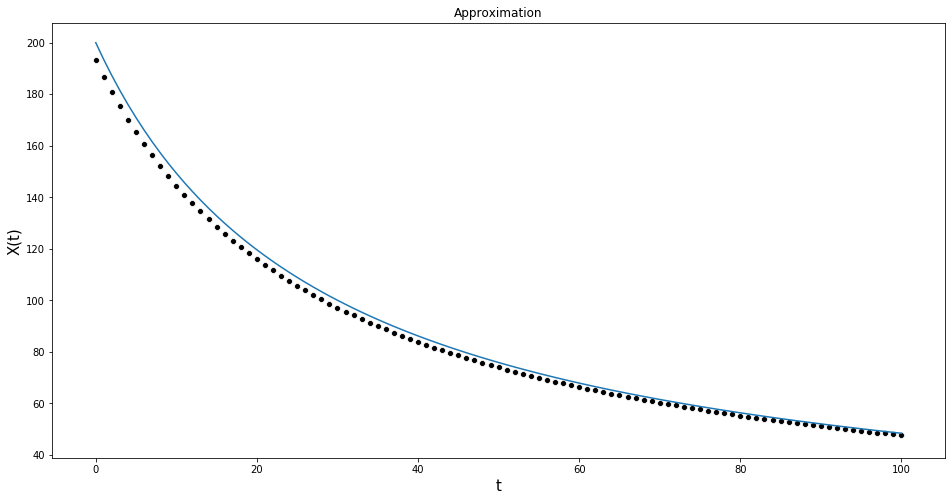

In [519]:
ver = Verhulst_Approximator(verhulst_params, verhulst_initial_condition)
ver.run()

## Oscilation

In [526]:
import seaborn as sns
def oscilation(z, t, delta, omega_0, omega, f):
    dx_dt = z[1]
    dy_dt = 2 * delta * z[1] - omega_0 ** 2 * z[0] - f * np.cos(omega * t)  
    return dx_dt, dy_dt

oscilate_params = {
    'delta': -0.1, 
    'omega': 1.,
    'omega_0': 0.,
    'f': 0.
}

oscilate_initial_condition=(1., 0.)

class Oscilate_Approximator:
    def __init__(self, 
                 oscilate_params,
                 oscilate_initial_condition,
                 noise=8,
                 step=10,
                 step_diff=1000,
                 t_begin=0,
                 t_end=400
                ):
        self.oscilate_params = oscilate_params
        self.oscilate_initial_condition = oscilate_initial_condition
        self.noise = noise
        self.step = step
        self.step_diff = step_diff
        self.t = np.arange(t_begin, t_end + 3, self.step / self.step_diff)
        self.data = self.extract_oscilation_features()
    
    def extract_oscilation_features(self):
        model = Model(oscilation, 'Oscilation')
        model.build(self.oscilate_params, self.oscilate_initial_condition, self.t)
        out = model.solved[:,0]
        theta = np.array([(2 - 2 * self.oscilate_params['delta'] - (self.oscilate_params['omega']**2) * self.step**2) / 
                          (1 - 2 * self.oscilate_params['delta'] * self.step),
                         1 / (2 * self.oscilate_params['delta'] * self.step - 1)])
        data = {
            't': self.t[0::self.step*self.step_diff][:-2],
            'x(t)': out[0::self.step*self.step_diff][:-2],
            'x(t+{})'.format(self.step):  out[0::self.step*self.step_diff][1:-1],
            'x(t+{})'.format(self.step*2):  out[0::self.step*self.step_diff][2:] # np.round(np.array([out[0::step*100][:-1], out[0::step*100][1:]]).T @ theta, noise)
        }
        return pd.DataFrame(data=data)

    def run(self):
        solver = Approximator(self.data.to_numpy())
        #tetas = solver.get_tetas(4)
        tetas = np.linalg.lstsq(self.data.to_numpy()[:,1:-1], self.data.to_numpy()[:,-1], rcond=1)[0]
        #tetas = RMNK(self.data.to_numpy()[:,1:-1], self.data.to_numpy()[:,-1], printt=True)[0][:,0]
        print(tetas)
        #variance = solver.get_variance()
        #mallows = solver.get_Mallows()
        #akaike = solver.get_Akaike()
        #print(variance, mallows, akaike)
        def findparams(theta1, theta2):
            r = - theta2
            k = (1 - theta1) / theta2
            return {'delta': -0.1, 'omega': 1., 'omega_0': 0., 'f': 0.}
        pred_params = findparams(tetas[0], tetas[1])
        print(pred_params)
        model = Model(oscilation, 'Oscilation')
        model.build(pred_params, self.oscilate_initial_condition, self.data['t'])
        model.plot(plot_y=False)
        #plt.figure(1)
        sns.scatterplot(self.data['t'][0::15], self.data['x(t+{})'.format(self.step*2)][0::15], color='black')
        plt.title('Approximation')
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)
        #RMNK(self.data.to_numpy()[:,1:-1], self.data.to_numpy()[:,-1], printt=True, cr_df=True)[3]


[-1.10219217e-08  5.21723438e-04]
{'delta': -0.1, 'omega': 1.0, 'omega_0': 0.0, 'f': 0.0}


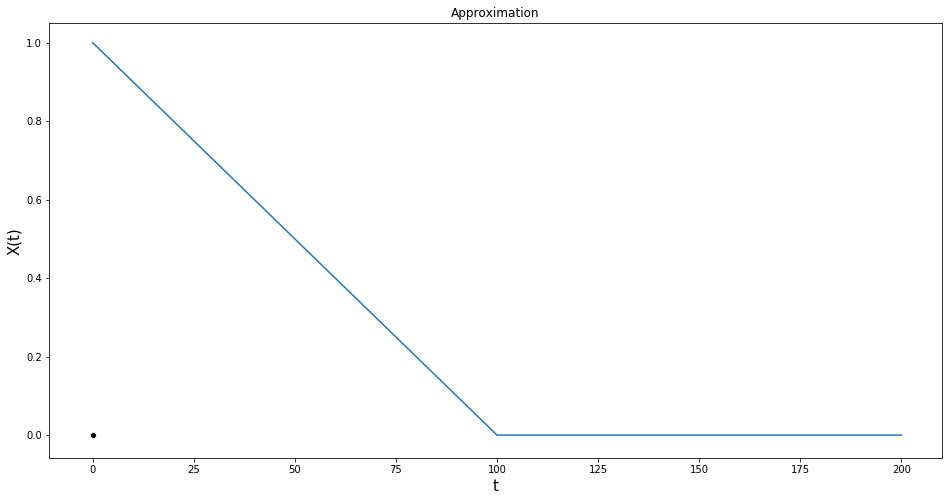

In [527]:
osc = Oscilate_Approximator(oscilate_params, oscilate_initial_condition)
osc.run()

## Generator

In [486]:
class Generator:
    def __init__(self, n, noise=0.01, theta=np.array([1,1,1,1,1,0,0,0,0,0])):
        self.X = np.random.uniform(0, 10, (n, theta.shape[0]))
        self.theta = theta
        self.noise = np.random.normal(0, noise, n)
        self.y = self.X @ self.theta + self.noise
    
    def run(self):
        print('n = {}'.format(self.noise.shape[0]))
        print('noise = {}'.format(self.noise))
        print('X:{}'.format(self.X.shape))
        print('y:{}'.format(self.y.shape))
        solver = Approximator(np.vstack((self.X.T, self.y.T)).T)
        tetas = solver.get_tetas(self.X.shape[1])
        print('True values: θ= {}'.format(self.theta))
        print('Estimates: θ*= {}'.format(tetas))
        #plt.plot(df['s'], df['RSS'], label='RSS')
        #plt.plot(df['s'], df['Cp'], label='Cp')
        #plt.plot(df['s'], df['FPE'], label='FPE')
        #plt.legend()
        #plt.show()
        #print(df)

In [487]:
Generator(20).run()

n = 20
noise = [ 0.00194318  0.0210645  -0.00428585  0.00455032 -0.00789537 -0.0016279
  0.00700804  0.01086973  0.01913912  0.00945962 -0.00141773  0.00921129
  0.00833612 -0.01248224  0.00942198 -0.00309842 -0.00178077 -0.00567044
  0.00393737 -0.00891643]
X:(20, 10)
y:(20,)
True values: θ= [1 1 1 1 1 0 0 0 0 0]
Estimates: θ*= [ 1.00087804e+00  1.00133178e+00  9.98970879e-01  9.99524396e-01
  1.00075178e+00  2.70156869e-04 -8.87273847e-04 -4.52177760e-04
 -3.70917777e-04  6.84150485e-04]


In [494]:
def extract_verhulst_features(verhulst_params, verhulst_initial_condition, noise=3, step=1e0, t_begin=0, t_end=100):
    t = np.arange(t_begin, t_end + 2, step / 100)
    model = Model(Verhulst, 'Verhulst')
    model.build(verhulst_params, verhulst_initial_condition, t)
    out = model.solved[:,0]
    theta = np.array([verhulst_params['r'] * verhulst_params['k'] + 1/step, - verhulst_params['r']])
    data = {
        't': t[0::100][:-1],
        'N(t)': out[0::100][:-1],
        'N^2(t)': np.square(out[0::100][:-1]),
        'N(t+{})'.format(step): out[0::100][1:] # np.round(np.array([out[0::100][:-1], np.square(out[0::100][:-1])]).T @ theta, noise)
    }
    return pd.DataFrame(data=data)

def extract_oscilation_features(oscilate_params, oscilate_initial_condition, noise=3, step=1, t_begin=0, t_end=100):
    t = np.arange(t_begin, t_end + 3, step/100)
    model = Model(oscilation, 'Oscilation')
    model.build(oscilate_params, oscilate_initial_condition, t)
    out = model.solved[:,0]
    theta = np.array([(2 - 2 * oscilate_params['delta'] - (oscilate_params['omega']**2) * step**2) / (1 - 2 * oscilate_params['delta'] * step),
                     1 / (2 * oscilate_params['delta'] * step - 1)])
    data = {
        't': t[0::step*100][:-2],
        'x(t)': out[0::step*100][:-2],
        'x(t+{})'.format(step):  out[0::step*100][1:-1], # out[0::step*100][2:] # 
        'x(t+{})'.format(step*2):  np.round(np.array([out[0::step*100][:-2], out[0::step*100][2:]]).T @ theta, noise)
    }
    return pd.DataFrame(data=data)

In [495]:
extract_oscilation_features(oscilate_params, oscilate_initial_condition)

,t,x(t),x(t+1),x(t+2)
0,0.0,1.000000,0.568972,1.215
1,1.0,0.568972,-0.258070,1.169
2,2.0,-0.258070,-0.720135,0.157
3,3.0,-0.720135,-0.498326,-0.802
4,4.0,-0.498326,0.098551,-0.919
...,...,...,...,...
96,96.0,0.000026,-0.000034,0.000
97,97.0,-0.000034,-0.000056,-0.000
98,98.0,-0.000056,-0.000027,-0.000
99,99.0,-0.000027,0.000019,-0.000


In [422]:
extract_verhulst_features(verhulst_params, verhulst_initial_condition)
#extract_oscilation_features(oscilate_params, oscilate_initial_condition)
solver = Approximator(extract_verhulst_features(verhulst_params, verhulst_initial_condition).to_numpy())
tetas = solver.get_tetas(4)
variance = solver.get_variance()
mallows = solver.get_Mallows()
akaike = solver.get_Akaike()
print('tetas are {}'.format(tetas))
print("Variance is " + str(variance))
print("Mallows is " + str(mallows))
print("Akaike is " + str(akaike))

tetas are [ 5.52972779e-10 -6.19888306e-06  8.14907253e-10  1.00000191e+00]
Variance is [[-5.81196408e+08]]
Mallows is [[-23966862.17256725]]
Akaike is [[-6.29130132e+08]]


In [423]:
solver = Approximator(extract_oscilation_features(oscilate_params, oscilate_initial_condition).to_numpy())
tetas = solver.get_tetas(3)
variance = solver.get_variance()
mallows = solver.get_Mallows()
akaike = solver.get_Akaike()
print('tetas are {}'.format(tetas))
print("Variance is " + str(variance))
print("Mallows is " + str(mallows))
print("Akaike is " + str(akaike))

tetas are [-6.45911738e-12 -8.18730785e-01  9.85392254e-01]
Variance is [[1.59520269]]
Mallows is [[0.06578155]]
Akaike is [[1.69286817]]


In [424]:
settings = (0, 10, 1)
step = 100

oscilate = Model(oscilation, 'Oscilation')
oscilate_params = {
    'delta': 0.1, 
    'omega': 0.5,
    'omega_0': 0.,
    'f': 0.
}
oscilate_initial_condition = (1., 0.)
oscilate_time_points = np.linspace(0, 400, 40000)
oscilate.build(oscilate_params, oscilate_initial_condition, oscilate_time_points)

y = oscilate.get_values(step)
h = (oscilate_time_points[-1] - oscilate_time_points[0])*step/len(oscilate_time_points)

orders = [3, 2, 1]
teta_1 = (oscilate_params['omega'] ** 2 - 2 + 2 * oscilate_params['delta']) / (2 * oscilate_params['delta'] - 1)
funcs = [lambda x: x, lambda x: x, lambda x: x]
data = form_discrete_values(funcs, y, orders)
params = oscilate.get_values(step)
delta = (1. / (2*h) ) * ((params[0]) + 1)
omega = ((params[1] * (2 * h * oscilate_params['delta'] - 1) + 
          (2 - 2 * h * oscilate_params['delta'])) ** 0.5) * (1. / h)

#print(delta)
#print(np.sqrt(params[0] * (2 * delta - 1) + 2 - 2 * delta))

# Example of how the code works with dummy data

In [425]:
X = np.array([[np.random.uniform(0, 1) for j in range(10)] for i in range(100)])
y = np.array([[np.random.uniform(0, 1)] for i in range(100)])
np.linalg.lstsq(X, y, rcond=1)[0]

oscilate = Model(oscilation, 'Oscilation')
solver = Approximator(data)
tetas = solver.get_tetas(2)
variance = solver.get_variance()
mallows = solver.get_Mallows()
akaike = solver.get_Akaike()
print(tetas)
print("variance is " + str(variance))
print("Mallows is " + str(mallows))
print("Akaike is " + str(akaike))

[-2.38218152  2.58247778]
variance is [[1.33106486e+35]]
Mallows is [[1.35477339e+33]]
Akaike is [[1.34454399e+35]]


## Example

In [426]:
def create_df(RSS_next,numOfColX,yShape):
    df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
    Cp = RSS_next + 2 * numOfColX
    numOfRowY = yShape
    FPE = (numOfRowY + numOfColX) / (numOfRowY - numOfColX) * RSS_next
    df = df.append({'s': numOfColX, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},  ignore_index=True)
    return df

def RMNK(X, y, s=None, printt=False, cr_df=False):
    numOfColX = X.shape[1]
    if numOfColX > 1:
        if cr_df:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, printt, cr_df)
            if s is not None and numOfColX > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, printt, cr_df)
            if s is not None and numOfColX > s:
                return w, H_inv, RSS
        
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) 
        η  = X[:,-1].T @ X[:,-1] 
        α = H_inv @ h 
        β  = η  - h.T @ α 
        β_inv = 1 /β  
        γ = X[:,-1].T @ y 
        ν =β_inv * (γ - h.T @ w) 
        w = np.vstack((w - ν * α, ν))  
        H_next_inv = np.vstack((np.hstack((H_inv + β_inv * α @ α.T, (- β_inv * α).reshape(-1, 1))),
                               np.hstack((-β_inv * α.T, β_inv))))
        RSS_next = (RSS - ν.flatten() ** 2 * β.flatten())[0]

    else: 
        H_inv = np.array([[0]])
        η  = β = X[:,-1].T @ X[:,-1]
        β_inv = 1 / β
        α = h = np.array([0])
        γ = X[:,-1].T @ y
        ν = np.array([β_inv * γ])
        w = np.array([ν])
        H_next_inv = np.array(β_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if cr_df:
            df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
        
    if printt:
        print('Step №{}'.format(numOfColX))
        '''print('h_{}:{}'.format(numOfColX, h.reshape(-1,1)[:,0]))
            print('η _{}:{}'.format(numOfColX, η ))
            print('α_{}:{}'.format(numOfColX, α.reshape(-1,1)[:,0]))
            print('β_{}:{}'.format(numOfColX, β))
            print('γ_{}:{}'.format(numOfColX, γ))
            print('ν_{}:{}'.format(numOfColX, ν))'''
        print('---θ{}: {}'.format(numOfColX, w[:, 0]))
        print('---H{}_inv:\n{}'.format(numOfColX, H_next_inv))
        print('---RSS{}: {}'.format(numOfColX, RSS_next))
    
    if cr_df:
        Cp = RSS_next + 2 * numOfColX
        numOfRowY = y.shape[0]
        FPE = (numOfRowY + numOfColX) / (numOfRowY - numOfColX) * RSS_next
        df = df.append({'s': numOfColX, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},  ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next


Fergulst Model:
μ = 0.0001
k = 10
N0 = 100
Noise: C = 4
n = 100
t =[0;1000] with h=10



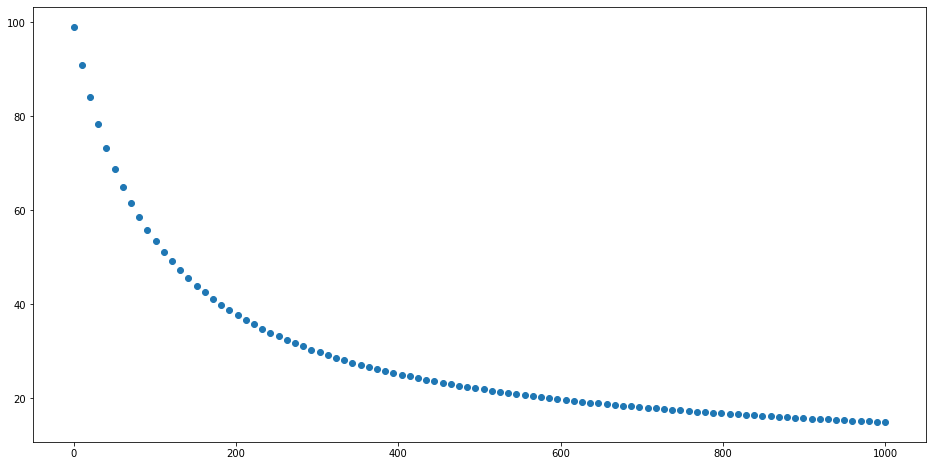

      i     t        N(t)        N^2(t)   N(t+1)
0     1     0  100.000000  10000.000000  99.1000
1     2    10   91.705134   8409.831579  90.9559
2     3    20   84.746199   7181.918243  84.1128
3     4    30   78.824789   6213.347354  78.2823
4     5    40   73.725211   5435.406776  73.2554
..  ...   ...         ...           ...      ...
95   96   959   15.261184    232.903728  15.2532
96   97   969   15.180913    230.460134  15.1730
97   98   979   15.102277    228.078781  15.0946
98   99   989   15.025230    225.757532  15.0177
99  100  1000   14.949727    223.494342  14.9423

[100 rows x 5 columns]
RMNKO:
Step №1
---θ1: [0.99550587]
---H1_inv:
[[8.46186225e-06]]
---RSS1: 0.8488937634974718
Step №2
---θ2: [ 1.00099975e+00 -9.99949621e-05]
---H2_inv:
[[ 4.40171822e-05 -6.47148226e-07]
 [-6.47148226e-07  1.17788513e-08]]
---RSS2: 8.286802521961789e-08
(array([[ 1.00099975e+00],
       [-9.99949621e-05]]), array([[ 4.40171822e-05, -6.47148226e-07],
       [-6.47148226e-07,  1.1778851

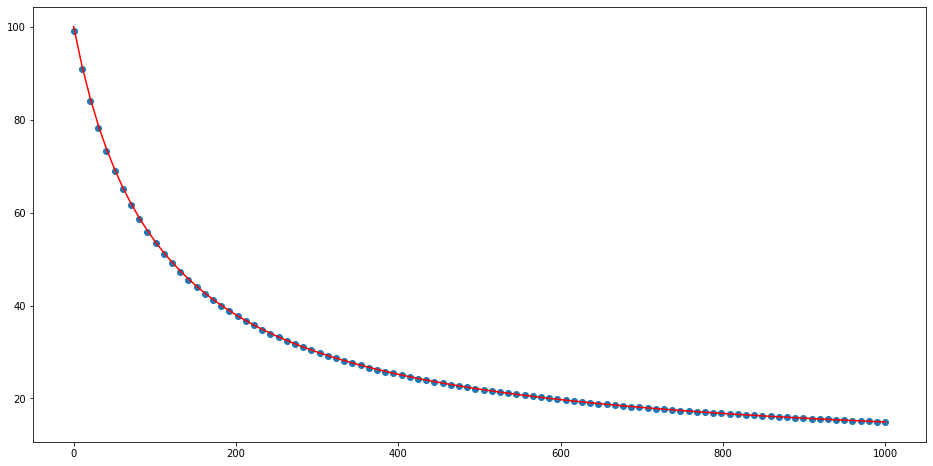

,C,n,θ_1*,θ_2*,μ*,k*
0,2.0,20.0,1.001003,-0.000100,0.000100,10.037421
1,2.0,50.0,1.001025,-0.000101,0.000101,10.196492
2,2.0,70.0,1.001015,-0.000100,0.000100,10.132916
3,5.0,20.0,1.001000,-0.000100,0.000100,10.000571
4,5.0,50.0,1.001000,-0.000100,0.000100,10.000262
5,5.0,70.0,1.001000,-0.000100,0.000100,10.000038
6,10.0,20.0,1.001000,-0.000100,0.000100,10.000000
7,10.0,50.0,1.001000,-0.000100,0.000100,10.000000
8,10.0,70.0,1.001000,-0.000100,0.000100,10.000000


In [427]:
def Fergulst(N, t, μ, k):
    return μ * N * (k - N)

def findtheta(μ,k):
    theta1 = μ * k + 1
    theta2 = -μ
    return np.array([theta1, theta2])

def findparams(theta1, theta2):
    μ = - theta2
    k = (1 - theta1) / theta2
    return μ, k

k = 10
μ = 0.0001
N0 = 100
t_start = 0
t_end = 1000
n = 100
n_list = [20, 50, 70]
C = 4
C_list = [2, 5, 10]

theta = findtheta(μ,k)
h = int((t_end - t_start) / (n - 1))
t = np.linspace(t_start, t_end, num=n)
N = odeint(Fergulst, N0, t, (μ, k))

df = pd.DataFrame()
df['i'] = range(1, n+1)
df['t'] = list(map(int, t))
df['N(t)'] = N.flatten()
df['N^2(t)'] = np.square(N.flatten())
df['N(t+1)'] = np.array(df[['N(t)','N^2(t)']]) @ theta
df['N(t+1)'] = np.round(df['N(t+1)'], C)
X = np.array(df[['N(t)', 'N^2(t)']])
y = np.array(df['N(t+1)'])
print('Fergulst Model:\nμ = {}\nk = {}\nN0 = {}'.format(μ, k, N0))
print('Noise: C = {}'.format(C))
print('n = {}'.format(n))
print('t =[{};{}] with h={}\n'.format(t_start,t_end,h))
plt.scatter(t, y)
plt.show()
print(df)
print('RMNKO:')
theta_est = RMNK(X, y, printt=True)
print(theta_est)
theta_est = theta_est[0][:,0]
print(theta_est)
μ_est, k_est = findparams(*theta_est)
print('True values/estimates:θ_1 = {} θ_2 = {} θ_1* = {} θ_2* = {}'.format(*theta,*theta_est))
print('True values/estimates: μ = {} k = {} μ* = {} k* = {}'.format(μ, k, μ_est, k_est))
plt.scatter(t, y)
t_plot = np.linspace(t_start, t_end, num=n)
plt.plot(t_plot, odeint(Fergulst, N0, t_plot, (μ_est, k_est)), 'r')
plt.show()
param_df = pd.DataFrame(columns=['C', 'n', 'θ_1*', 'θ_2*', 'μ*', 'k*'])
for C in C_list:
    for n in n_list: 
        h = int((t_end - t_start) / (n - 1))
        t = np.linspace(t_start, t_end, num=n)
        N = odeint(Fergulst, N0, t, (μ, k))
        df = pd.DataFrame()
        df['i'] = range(1, n+1)
        df['t'] = list(map(int, t))
        df['N(t)'] = N.flatten()
        df['N^2(t)'] = np.square(N.flatten())
        df['N(t+1)'] = np.array(df[['N(t)','N^2(t)']]) @ theta
        df['N(t+1)'] = np.round(df['N(t+1)'], C)
        X = np.array(df[['N(t)', 'N^2(t)']])
        y = np.array(df['N(t+1)'])
        theta_est = RMNK(X, y, printt=False)[0][:,0]
        μ_est, k_est = findparams(*theta_est)
        param_df = param_df.append({'C': C, 'n': n,'θ_1*': theta_est[0], 'θ_2*': theta_est[1],'μ*': μ_est, 'k*': k_est}, ignore_index=True)
param_df

δ = 0.005 ω0^2 = 0.01 x0 = 5 x00 = 2
C = 2
n = 100
t =[0;1000] with h=10



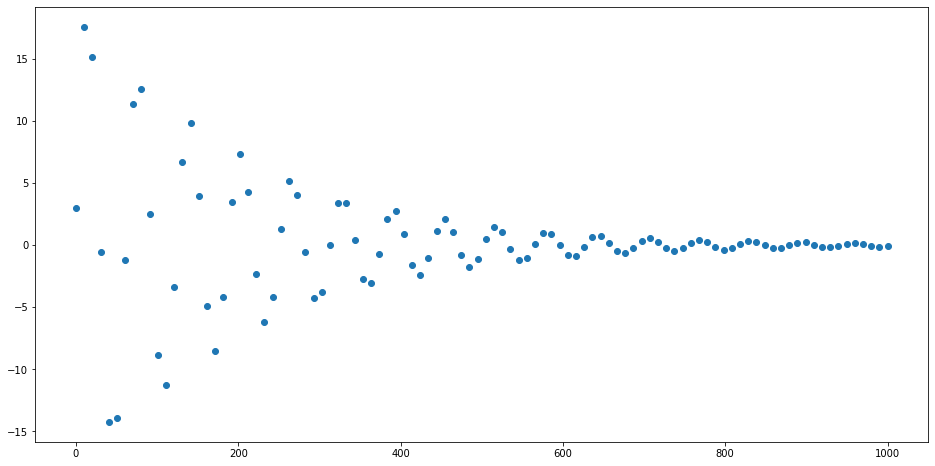

      i     t       x(t)     x(t+1)  x(t+2)
0     1     0   5.000000   7.000000    2.97
1     2    10  18.845271  19.939029   17.58
2     3    20  14.574472  13.874824   15.12
3     4    30  -2.267788  -3.965348   -0.56
4     5    40 -15.471944 -16.559489  -14.24
..  ...   ...        ...        ...     ...
95   96   959   0.166296   0.166775    0.16
96   97   969   0.048257   0.035219    0.06
97   98   979  -0.101425  -0.115068   -0.09
98   99   989  -0.146385  -0.148422   -0.14
99  100  1000  -0.056637  -0.046370   -0.07

[100 rows x 5 columns]
RMNKO
Step №1
---θ1: [0.95814633]
---H1_inv:
[[0.00045498]]
---RSS1: 19.32925232365642
Step №2
---θ2: [ 1.98091079 -0.9906825 ]
---H2_inv:
[[ 0.05457455 -0.05242195]
 [-0.05242195  0.05077759]]
---RSS2: 0.0008069832257255882
true values/estimates:θ_1 = 1.98019801980198 θ_2 = -0.9900990099009901 θ_1* = 1.9809107895197042 θ_2* = -0.9906825049560994
true values/estimates: δ = 0.005 ω0^2 = 0.01 δ* = 0.0047025636353159594 ω0^2* = 0.00986361966372695

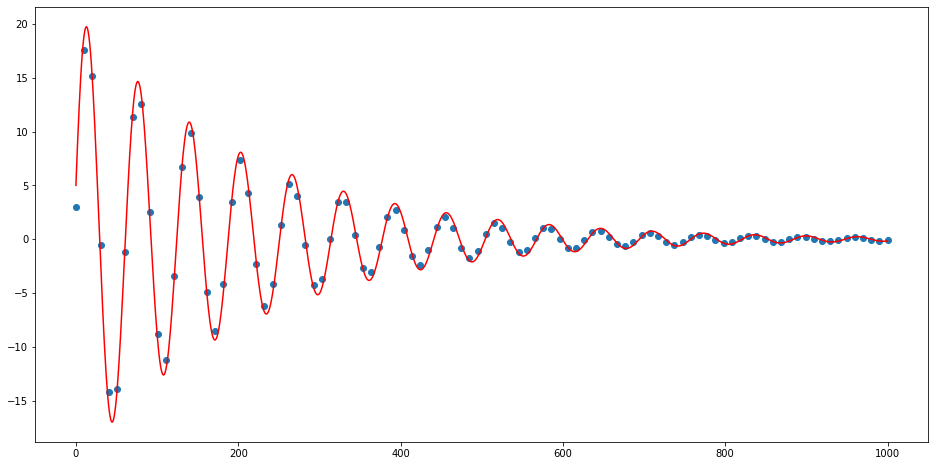

,C,n,θ_1*,θ_2*,δ*,ω0_sqr*
0,2.0,20.0,1.978366,-0.988289,0.005925,0.010041
1,2.0,50.0,1.980542,-0.990451,0.004821,0.010005
2,2.0,150.0,1.979551,-0.989452,0.005330,0.010007
3,5.0,20.0,1.980197,-0.990098,0.005001,0.010000
4,5.0,50.0,1.980198,-0.990099,0.005000,0.010000
5,5.0,150.0,1.980197,-0.990098,0.005000,0.010000
6,10.0,20.0,1.980198,-0.990099,0.005000,0.010000
7,10.0,50.0,1.980198,-0.990099,0.005000,0.010000
8,10.0,150.0,1.980198,-0.990099,0.005000,0.010000


In [428]:
def ZgasColiv(x, t, δ, ω0_sqr):
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]        
def findtheta(δ,ω0_sqr):
    d = 1 + 2 * δ
    theta1 = (2 + 2 * δ - ω0_sqr) / d
    theta2 = - 1 / d
    return np.array([theta1, theta2])
def findparams(theta1, theta2):
    δ = - (1 / theta2 + 1) / 2
    ω0_sqr = 1 - 1 / theta2 + theta1 / theta2
    return δ, ω0_sqr
 
δ = 0.005
ω0_sqr = 0.01
x0 = 5
x00 = 2
t_start = 0
t_end = 1000
n = 100
n_list = [20, 50, 150]
C = 2
C_list = [2, 5, 10]

theta = findtheta(δ,ω0_sqr)
h = int((t_end - t_start) / (n - 1))
t = np.linspace(t_start, t_end, num=n)
x = odeint(ZgasColiv, np.array([x0, x00]), t, (δ, ω0_sqr))
x1 = x0 + x00
x11 = x00
x_1 = odeint(ZgasColiv, np.array([x1, x11]), t+1, (δ, ω0_sqr))
df = pd.DataFrame()
df['i'] = range(1, n+1)
df['t'] = list(map(int, t))
df['x(t)'] = x[:,0].flatten()
df['x(t+1)'] = x_1[:,0].flatten()
df['x(t+2)'] = np.array(df[['x(t)','x(t+1)']]) @ theta
df['x(t+2)'] = np.round(df['x(t+2)'], C)
X = np.array(df[['x(t)', 'x(t+1)']])
y = np.array(df['x(t+2)'])  
    
print('δ = {} ω0^2 = {} x0 = {} x00 = {}'.format(δ, ω0_sqr, x0, x00))
print('C = {}'.format(C))
print('n = {}'.format(n))
print('t =[{};{}] with h={}\n'.format(t_start,t_end,h))
plt.scatter(t, y)
plt.show()
print(df)

print('RMNKO')
theta_pred = RMNK(X, y, printt=True)[0][:,0]
δ_pred, ω0_sqr_pred = findparams(*theta_pred)
print('true values/estimates:θ_1 = {} θ_2 = {} θ_1* = {} θ_2* = {}'.format(*theta,*theta_pred))
print('true values/estimates: δ = {} ω0^2 = {} δ* = {} ω0^2* = {}'.format(δ, ω0_sqr,δ_pred, ω0_sqr_pred))
plt.scatter(t, y)
t_plot = np.linspace(t_start, t_end, num=n * 10)
plt.plot(t_plot, odeint(ZgasColiv, np.array([x0, x00]),t_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

param_df = pd.DataFrame(columns=['C', 'n', 'θ_1*', 'θ_2*','δ*', 'ω0_sqr*'])
for C in C_list:
    for n in n_list: 
        h = int((t_end - t_start) / (n - 1))
        t = np.linspace(t_start, t_end, num=n)
        x = odeint(ZgasColiv, np.array([x0, x00]), t, (δ, ω0_sqr))
        x1 = x0 + x00
        x11 = x00
        x_1 = odeint(ZgasColiv, np.array([x1, x11]), t+1, (δ, ω0_sqr))
        df = pd.DataFrame()
        df['i'] = range(1, n+1)
        df['t'] = list(map(int, t))
        df['x(t)'] = x[:,0].flatten()
        df['x(t+1)'] = x_1[:,0].flatten()
        df['x(t+2)'] = np.array(df[['x(t)','x(t+1)']]) @ theta
        df['x(t+2)'] = np.round(df['x(t+2)'], C)
        X = np.array(df[['x(t)', 'x(t+1)']])
        y = np.array(df['x(t+2)'])  
        theta_pred = RMNK(X, y, printt=False)[0][:,0]
        δ_pred, ω0_sqr_pred = findparams(*theta_pred)
        param_df =param_df.append({'C': C, 'n': n,'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1],'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},ignore_index=True)       
param_df



n = 10
σ = 0.1
X:[[2.40955773 6.26030113 4.24502589 9.21702596 8.16284762]
 [1.05492357 2.57705047 8.80164326 9.61661647 4.67558556]
 [7.09722124 3.68033075 6.64261626 1.93647498 9.65254849]
 [2.70941749 5.31969279 3.34407807 6.06986417 1.95319157]
 [9.22933826 4.47817232 4.40443236 4.63916417 2.40031289]
 [0.235784   8.36032135 3.28553554 1.58421185 7.26837635]
 [9.81038645 8.65600419 9.59903595 3.76682462 5.19743625]
 [0.39351985 6.7402293  9.52542156 4.20328215 5.09930122]
 [6.72435604 5.6775939  6.58062546 7.39399231 2.48028866]
 [0.50027089 5.9601157  9.08677059 1.18458724 4.49109554]]
y:[ -1.04575999   6.79902229  20.57509812   0.82809416  23.15421602
 -12.74926865  21.72227086  -2.76816754  15.40548565  -1.33055598]
Step №1
---θ1: [2.32595093]
---H1_inv:
[[0.0034278]]
---RSS1: 310.3353614972948
Step №2
---θ2: [ 3.17957771 -1.08100575]
---H2_inv:
[[ 0.00681991 -0.00429566]
 [-0.00429566  0.00543989]]
---RSS2: 95.51969017950557
Step №3
---θ3: [ 3.00164692 -2.00137668  1.0002858 ]


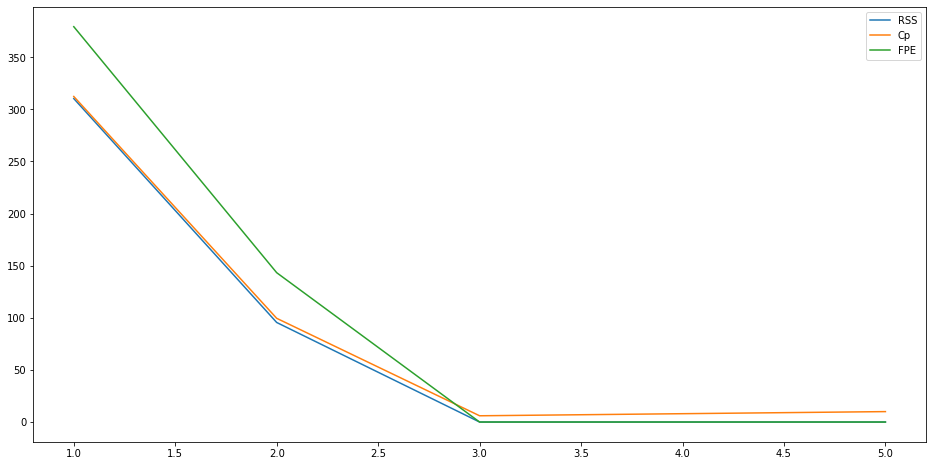

     s         RSS          Cp         FPE
0  1.0  310.335361  312.335361  379.298775
1  2.0   95.519690   99.519690  143.279535
2  3.0    0.000673    6.000673    0.001250
3  4.0    0.000657    8.000657    0.001533
4  5.0    0.000565   10.000565    0.001694

n = 10
σ = 0.5
X:[[3.78229061 8.83251611 5.85683124 4.81476689 1.83903271]
 [6.7007539  3.82833052 9.15645977 4.86010845 5.78466829]
 [2.5340345  5.76074989 2.16150296 2.99247652 2.81819377]
 [0.87266156 6.09115668 6.6567     2.22971736 6.07427942]
 [5.32750946 5.28379988 0.65108096 7.37655557 6.27609269]
 [9.49198623 5.73759532 2.75707039 0.1846066  6.10960463]
 [1.01169062 4.75409655 6.41684944 4.15530041 1.64194435]
 [8.4326078  0.15595114 2.02664003 6.93561081 2.05688074]
 [3.09611013 5.22503457 4.65015225 6.0497742  1.19484403]
 [6.64191305 7.87710362 3.78722201 6.04687065 5.59118032]]
y:[-0.4625167  21.59855243 -1.75487068 -2.9093856   6.06569887 19.77235008
 -0.06215526 27.01671651  3.50075718  7.95429817]
Step №1
---θ1: [2.

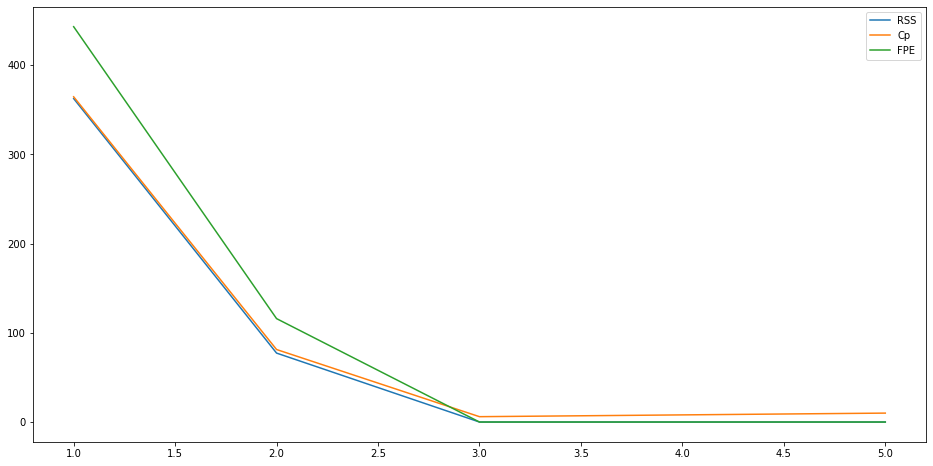

     s         RSS          Cp         FPE
0  1.0  362.400939  364.400939  442.934481
1  2.0   77.239582   81.239582  115.859373
2  3.0    0.000335    6.000335    0.000621
3  4.0    0.000305    8.000305    0.000713
4  5.0    0.000274   10.000274    0.000821

n = 10
σ = 1
X:[[6.65643551 9.68859452 3.83257225 9.57931886 8.82991656]
 [0.06381473 8.95149337 2.16751739 3.97162529 4.96160655]
 [2.42591533 1.30737341 6.89905619 5.03233944 0.30551215]
 [7.9218206  3.39296532 9.34734883 3.72327624 5.49397968]
 [7.91969114 9.62051845 8.5163779  2.73076773 6.94567241]
 [5.96405645 0.13094095 2.84543893 5.25331761 9.70046955]
 [3.76034074 0.84767489 9.80018441 0.98073475 2.31754419]
 [2.05906442 7.33879723 6.38559905 2.36619662 5.10667077]
 [6.63327903 4.59043689 9.43983583 3.82767025 2.88355305]
 [6.29447483 4.47247025 4.54152133 3.75449101 3.4653629 ]]
y:[  4.43200074 -15.53806901  11.56344854  26.32503387  13.02516001
  20.47716511  19.39375566  -2.11943152  20.15145455  14.47963801]
Step №1
--

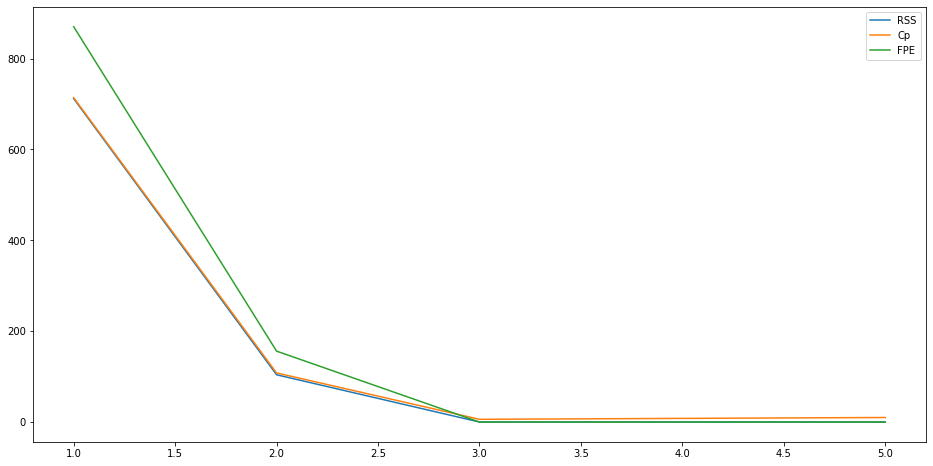

     s         RSS          Cp         FPE
0  1.0  712.087154  714.087154  870.328744
1  2.0  104.057627  108.057627  156.086441
2  3.0    0.000308    6.000308    0.000572
3  4.0    0.000182    8.000182    0.000425
4  5.0    0.000173   10.000173    0.000520

n = 30
σ = 0.1
X:[[5.62929883 6.70117315 5.96286348 6.93150854 1.16310136]
 [1.84978625 2.43919192 8.99160933 7.58263587 2.19964946]
 [7.18136918 7.42477406 6.11293125 7.96951795 2.8838905 ]
 [3.38488167 2.33077611 2.79313046 8.32979735 6.32262215]
 [8.59875707 1.3258913  1.46603613 6.70702782 7.16708276]
 [8.97275104 0.46712084 6.79653652 6.62570823 9.255565  ]
 [1.25422691 3.08928984 7.97011794 3.14864305 4.2718045 ]
 [5.11943095 3.43399025 4.96756495 3.6892974  3.62389005]
 [5.63964033 0.99882926 2.36259544 9.89905552 3.43980277]
 [1.23141757 9.51491723 3.25280096 9.30565832 0.7232198 ]
 [3.15004195 8.61978439 8.96782037 6.23066558 5.01412074]
 [5.13779046 0.42306653 8.3613837  9.61986669 9.97578913]
 [3.10214509 6.49325293 5.87

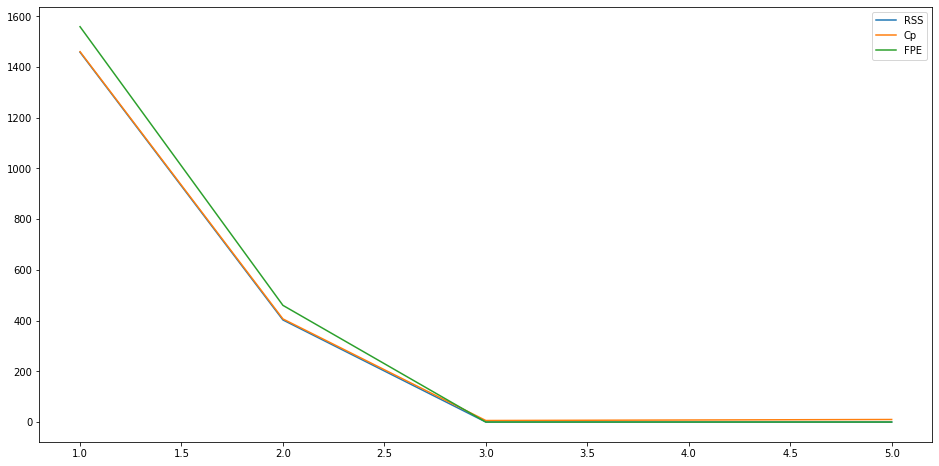

     s          RSS           Cp          FPE
0  1.0  1458.624896  1460.624896  1559.219716
1  2.0   402.600204   406.600204   460.114519
2  3.0     0.002574     6.002574     0.003146
3  4.0     0.002572     8.002572     0.003363
4  5.0     0.002493    10.002493     0.003490

n = 30
σ = 0.5
X:[[4.06139787 1.86182193 1.14569676 0.77932743 5.48557651]
 [5.2178617  1.33996023 4.76498062 2.0606514  6.04858079]
 [0.77224589 8.26973609 6.481838   8.96135146 7.09120998]
 [9.10668745 3.15840547 4.88917449 1.99585739 8.19088316]
 [2.27137024 9.69414632 0.6224892  3.56366589 2.26600189]
 [0.68267043 9.57569859 2.06955736 9.51991946 9.12290148]
 [5.18454127 5.9044703  9.38947442 1.20176438 6.85636286]
 [7.79523204 3.91382578 6.43766425 7.2140274  7.88643811]
 [4.84747566 7.75222731 2.13941712 3.94879728 7.33422752]
 [5.28967944 8.92442135 4.70808281 9.68973128 8.64201641]
 [9.19931136 9.54145946 0.17844225 7.14290225 1.26638212]
 [0.36895324 3.77879498 3.13722938 0.54074904 9.14210573]
 [5.660906

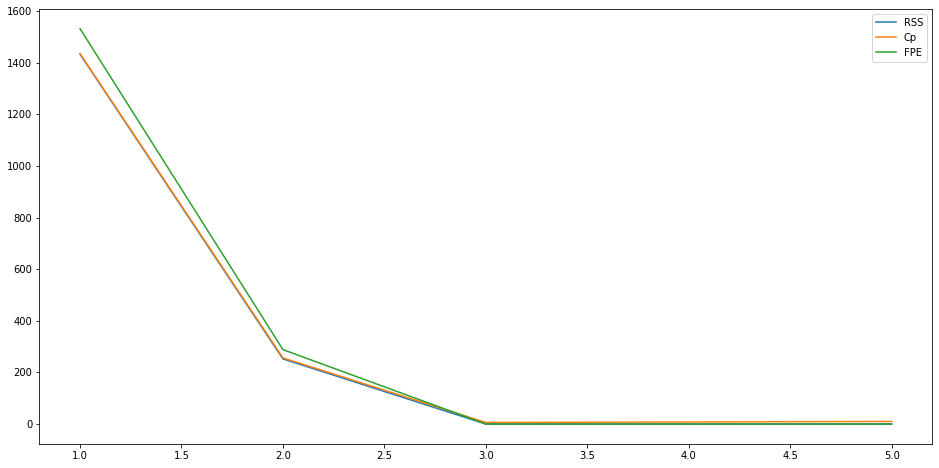

     s          RSS           Cp          FPE
0  1.0  1433.155108  1435.155108  1531.993391
1  2.0   252.342967   256.342967   288.391963
2  3.0     0.003952     6.003952     0.004831
3  4.0     0.003946     8.003946     0.005160
4  5.0     0.003870    10.003870     0.005418

n = 30
σ = 1
X:[[1.97711169 1.77730138 3.49739202 3.51329599 2.62687173]
 [7.33943104 9.93964199 8.87550876 6.18832795 2.47721253]
 [5.66147472 2.49659748 9.60860256 2.53917199 2.31920366]
 [8.61023268 7.14898779 4.11695197 0.13476712 0.69970643]
 [9.24675499 1.74720032 5.6658515  1.25408502 8.32992761]
 [2.73532954 0.347145   8.21384275 6.1654453  8.44798673]
 [3.03878135 6.2749821  8.41063626 1.24383749 6.83707775]
 [8.91764023 5.17699182 2.08275492 5.17632934 6.72604307]
 [7.56846568 3.11045296 2.97510442 5.63416651 1.86356855]
 [6.12592068 6.48274021 2.04280112 8.67855427 0.4879233 ]
 [4.26448439 3.1089741  4.64532333 8.29635559 8.09203399]
 [5.35774671 1.38515473 9.98153893 2.39377762 4.60025076]
 [2.57077059

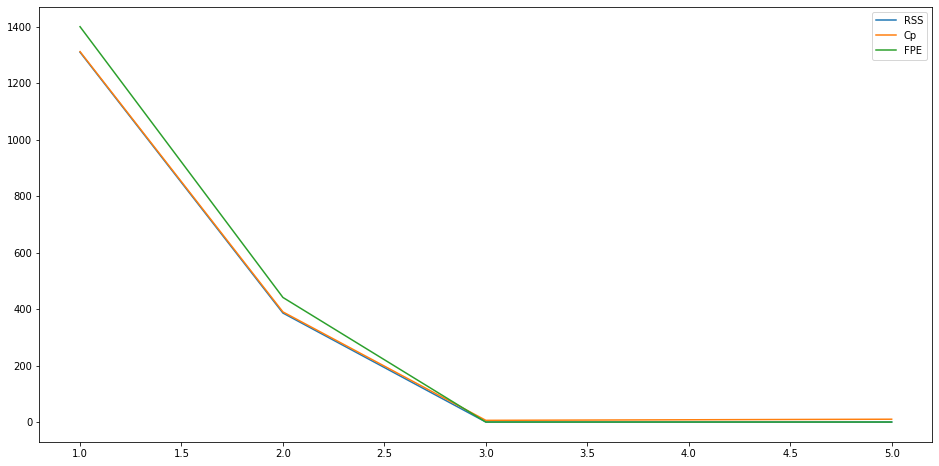

     s          RSS           Cp          FPE
0  1.0  1309.503597  1311.503597  1399.814190
1  2.0   385.912056   389.912056   441.042350
2  3.0     0.003483     6.003483     0.004257
3  4.0     0.003006     8.003006     0.003931
4  5.0     0.002810    10.002810     0.003934

n = 100
σ = 0.1
X:[[4.42899277e+00 8.99938345e+00 9.80228767e-01 3.31686033e+00
  5.15954045e+00]
 [9.99501637e+00 3.44546153e+00 5.43324496e+00 6.40197034e+00
  3.43517159e-02]
 [7.34683064e+00 8.49885819e+00 6.53018855e+00 6.09280356e-01
  7.96309920e-01]
 [2.37025584e+00 9.30408089e-01 9.44173779e-01 9.39787858e+00
  5.68254919e+00]
 [1.87841138e+00 9.43069856e-01 8.03134699e+00 4.76072769e+00
  7.65416033e-01]
 [3.03552123e+00 9.24221540e+00 1.93972147e+00 8.10077041e+00
  7.86997782e+00]
 [6.88789192e+00 8.11359381e+00 4.39866871e+00 9.91863878e+00
  6.67214787e+00]
 [7.79331886e+00 7.94382263e+00 3.04670136e+00 5.02076896e+00
  9.80520421e+00]
 [4.20183033e+00 6.33005741e+00 5.32108206e+00 5.82437166e+00
  9

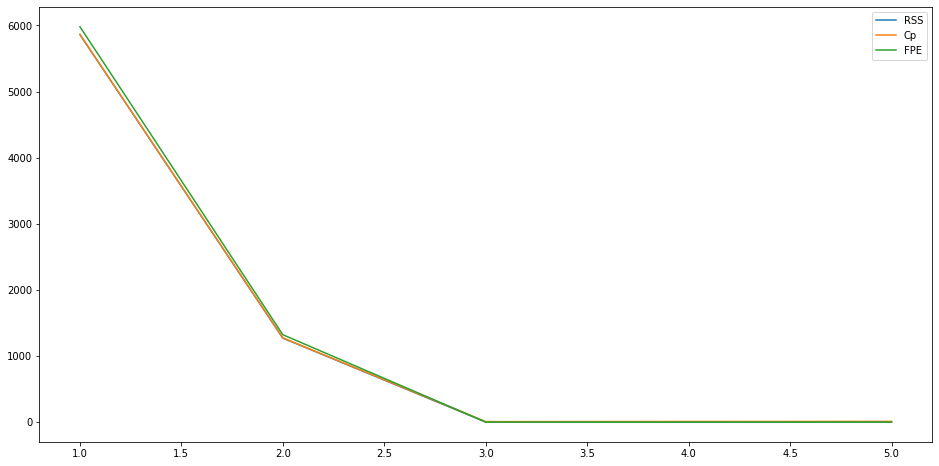

     s          RSS           Cp          FPE
0  1.0  5862.007265  5864.007265  5980.431654
1  2.0  1269.172333  1273.172333  1320.975285
2  3.0     0.009501     6.009501     0.010088
3  4.0     0.009466     8.009466     0.010255
4  5.0     0.009444    10.009444     0.010439

n = 100
σ = 0.5
X:[[5.81170900e+00 5.52253231e+00 8.02568349e+00 6.32088851e+00
  5.99680883e+00]
 [4.22187038e+00 2.75739982e+00 5.12230231e+00 9.53317255e+00
  2.20212645e+00]
 [3.57651390e-01 1.50065918e-01 3.51995084e+00 6.80273798e+00
  2.98989606e+00]
 [5.60062976e+00 8.33706860e-01 8.80322360e-01 9.76752545e+00
  7.31264877e+00]
 [5.64346339e+00 8.54817839e+00 9.72535679e+00 7.08408778e+00
  9.81484486e+00]
 [4.52460376e+00 3.60689828e+00 1.75318722e+00 9.68831936e+00
  3.55175215e+00]
 [2.60768124e+00 8.41672306e-01 2.10853957e+00 5.63643397e+00
  4.12347115e+00]
 [5.10231827e+00 5.79032792e+00 3.06934128e+00 8.54034371e-01
  1.38743407e+00]
 [7.55827980e+00 7.93206905e-01 7.87438887e+00 8.95241440e+00
  9

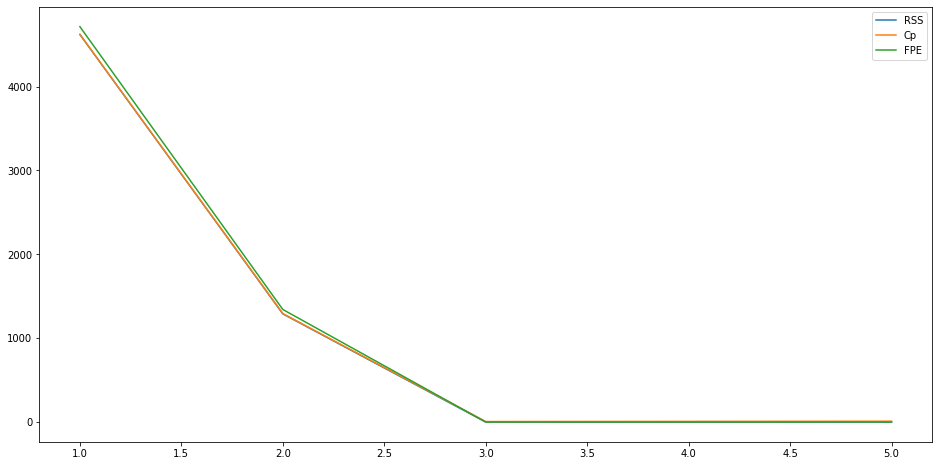

     s          RSS           Cp          FPE
0  1.0  4620.677920  4622.677920  4714.024949
1  2.0  1289.584666  1293.584666  1342.220775
2  3.0     0.009884     6.009884     0.010496
3  4.0     0.009599     8.009599     0.010399
4  5.0     0.009587    10.009587     0.010596

n = 100
σ = 1
X:[[2.64325905 2.79650232 0.5104991  4.61521817 2.9248607 ]
 [6.12596623 3.19335953 0.99863818 0.83043739 6.29767899]
 [3.22276408 0.37156532 0.59727491 8.96183802 9.24792515]
 [1.76055428 1.2874115  8.20085581 4.82433427 7.3605778 ]
 [1.0803961  4.04331315 2.14711934 1.62859253 8.82011427]
 [3.42615406 4.65982617 5.60239247 3.7508484  7.08466126]
 [0.45501261 5.25008646 8.92653584 1.09204554 2.92463664]
 [9.54666493 5.27610039 1.50454475 0.91993259 1.85524666]
 [6.79155267 3.30172828 6.09454591 7.09901524 4.59738481]
 [3.3250209  8.83941995 6.99284917 4.62591312 0.01230388]
 [6.49266465 3.56390064 4.22759327 5.53142312 1.96350261]
 [5.39378047 0.21177742 1.82597549 9.89609255 7.78246777]
 [0.2199062

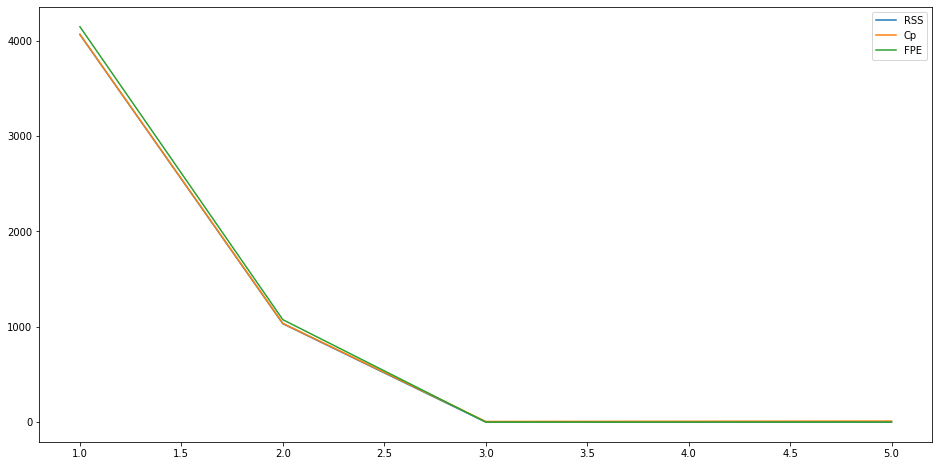

     s          RSS           Cp          FPE
0  1.0  4066.042301  4068.042301  4148.184570
1  2.0  1031.988077  1035.988077  1074.110040
2  3.0     0.010793     6.010793     0.011461
3  4.0     0.010792     8.010792     0.011692
4  5.0     0.010707    10.010707     0.011834



In [429]:
m = 5
n_list = [10, 30, 100]
theta = np.array([3, -2, 1, 0, 0])
sigma_list = [0.1, 0.5, 1]
s = 5
for n in n_list: 
    for sigma in sigma_list:
        X = np.random.uniform(0, 10, size=(n, m))
        ksi = np.random.normal(0, 0.01, size=n)
        y = X @ theta + ksi
        print('n = {}'.format(n))
        print('σ = {}'.format(sigma))
        print('X:{}'.format(X))
        print('y:{}'.format(y))
        theta_pred, _, _, df = RMNK(X, y, s=s, printt=True, cr_df=True)
        #p = np.flip(np.arange(m), axis=0)
        #theta_pred, _, _, df = RMNK(X[:,p], y, s=s, printt=True, cr_df=True)
        print('True values: θ= {}'.format(theta))
        print('Estimates: θ*= {}'.format(theta_pred[:,0]))
        plt.plot(df['s'], df['RSS'], label='RSS')
        plt.plot(df['s'], df['Cp'], label='Cp')
        plt.plot(df['s'], df['FPE'], label='FPE')
        plt.legend()
        plt.show()
        print(df)
        print()